# CESP Optimizer on 2D function
In this notebook we evaluate the convergence of GD against our curvature exploitation approach, CESP, on a two-dimensional saddle point problem of the form:
$$ \min_x \max_y \; \left[ \,f(x, y) = 2x + y +4xy + 4/3 y^3 - 0.25 y^4 \,\right]$$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

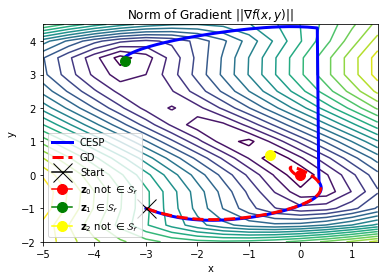

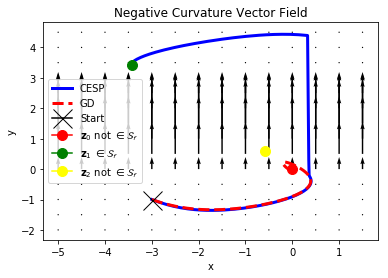

In [9]:
alpha = 2
beta = 1
M = 4
gamma = 4./3.
delta = -0.25

def _fun(x,y):
    return alpha * x + beta * y + M * x*y + gamma * y**3 + delta* y**4

def _derivative(x,y):
    return np.array([2*alpha*x + M*y, 2*beta*y + M*x + 3.*gamma * y**2 + 4.*delta * y**3 ])

def _hessian_x():
    return 2*alpha

def _hessian_y(y):
    return 2 + 8.*y - 3.*y**2

def GD(x0, maxiter=300, noise_var=0., eta=0.001):
    x = x0
    x_hist = [x]
    r_hist = []
    for i in range(maxiter):
        noise = np.random.normal(0, noise_var, size=2)
        r_hist.append(_derivative(x[0], x[1]))
        r = _derivative(x[0], x[1]) + noise
        # The change in sign is because of the simultaneous Gradient Descent/Ascent Step
        step = np.array([-eta ,eta])
        x_new = x + step* r 
        x_hist.append(x_new)
        x = x_new
    return x_hist

def CESP(x0, maxiter=300, eta=0.01, alpha=0.001):
    x = x0
    x_hist = [x]
    for i in range(maxiter):
        r = _derivative(x[0], x[1])
        v, alpha = get_nc_direction(x[1], r[1])
        nc_update = alpha * v
        r = _derivative(x[0], x[1])
        step = np.array([-eta *1 ,eta])
        x_new = x + step* r + nc_update
        x_hist.append(x_new)
        x = x_new
    return x_hist

def get_nc_direction(y, dy):
    vx = 0 # always 0, because hessian_x is constant > 0
    eig = _hessian_y(y)
    if eig <= 0:
        return np.array([vx, 0]), 0.
    vy = 1
    if dy < 0:
        vy = -1
    return np.array([vx, vy]), eig

def plt_background(_bg="grad"):
    plt.figure()
    x = np.arange(-5, 2, 0.5)
    y = np.arange(-2, 5, 0.5)
    X,Y = np.meshgrid(x,y)
    x = np.reshape(X, -1)
    y = np.reshape(Y, -1)
    plt.xlabel("x")
    plt.ylabel("y")
    if _bg == "grad":
        Z = np.reshape(np.array([np.linalg.norm(_derivative(x[i], y[i])) for i in range(len(x))]), [len(X), len(X)])
        plt.contour(X,Y,Z,20)
        plt.title(r"Norm of Gradient $|| \nabla f(x,y) ||$")
    elif _bg == "vec":
        U = np.zeros_like(X)
        V = np.zeros_like(Y)

        for i, y in enumerate(Y):
            lam = _hessian_y(y[0])
            if lam > 0:
                V[i, :] = lam
        Q = plt.quiver(X, Y, U, V)
        plt.title("Negative Curvature Vector Field")
    else:
        raise NotImplementedError()
        
def plt_trajectories(traj_gd, traj_cesp):
    plt.plot(np.array(traj_cesp)[:,0], np.array(traj_cesp)[:,1], 'b',label="CESP", linewidth=3.0)
    plt.plot(np.array(traj_gd)[:,0], np.array(traj_gd)[:,1], 'r--',label="GD", linewidth=3.0)
    plt.plot(x0[0], x0[1], marker='x', markersize=19, color="k", label='Start')
    plt.plot(0, 0, marker='o', markersize=10, color="red", label='$\mathbf{z}_0$ not $\in \mathcal{S}_{\mathcal{f}}$')
    plt.plot(-2-np.sqrt(2), 2+np.sqrt(2), marker='o', markersize=10, color="green", label='$\mathbf{z}_1$ $\in \mathcal{S}_{\mathcal{f}}$')
    plt.plot(-2+np.sqrt(2), 2-np.sqrt(2), marker='o', markersize=10, color="yellow", label='$\mathbf{z}_2$ not $\in \mathcal{S}_{\mathcal{f}}$')
    plt.legend()
    plt.show()
    
x0 = np.array([-3., -1.])
traj_gd = GD(x0, noise_var=0., maxiter=5000)
traj_cesp = CESP(x0, maxiter=5000)

plt_background("grad")
plt_trajectories(traj_gd, traj_cesp)

plt_background("vec")
plt_trajectories(traj_gd, traj_cesp)

# To which point do the methods converge for different initializations?

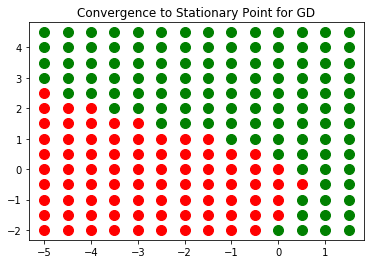

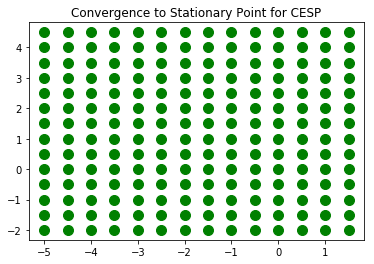

In [4]:
def check_state(x):
    state = 3 # diverged
    eps = 0.2
    if np.linalg.norm(x-c1) < eps:
        state = 0
    elif np.linalg.norm(x-c2) < eps:
        state = 1
    elif np.linalg.norm(x-c3) < eps:
        state = 2
    return state

x = np.arange(-5, 2, .5)
y = np.arange(-2, 5, .5)
X,Y = np.meshgrid(x,y)
x = np.reshape(X, -1)
y = np.reshape(Y, -1)

c1, c2, c3 = np.array([0,0]), np.array([-2-np.sqrt(2), 2+np.sqrt(2)]), np.array([-2+np.sqrt(2), 2-np.sqrt(2)])
states = {"GD": [], "CESP": []}
for i in range(len(x)):
    traj = GD([x[i], y[i]], maxiter=5000)
    traj2 = CESP([x[i], y[i]], maxiter=5000)
    states["GD"].append(check_state(traj[-1]))
    states["CESP"].append(check_state(traj2[-1]))
    
color = ["red", "green", "yellow", "black"]
plt.figure()
for i in range(len(x)):
    plt.plot(x[i], y[i], marker='o', markersize=10, color=color[states["GD"][i]])
plt.title("Convergence to Stationary Point for GD")
plt.show()  
# plt.savefig("initialization_convergence_GD.png")


plt.figure()
for i in range(len(x)):
    plt.plot(x[i], y[i], marker='o', markersize=10, color=color[states["CESP"][i]])
plt.title("Convergence to Stationary Point for CESP")
plt.show() 
# plt.savefig("initialization_convergence_CEGD.png")
    

# What if we add noise to GD?

In [10]:
_vars = [0., 1., 5.]
x0 = np.array([-3., -1.])
trajs = []
for var in _vars:
    trajs.append(GD(x0, noise_var=var, maxiter=5000, eta=0.0005))

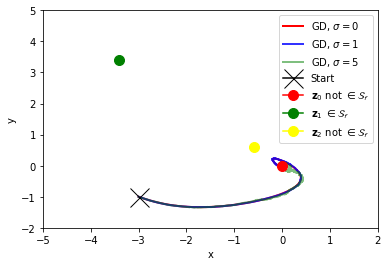

In [11]:
_c = ["r", "b", "g"]
_alpha = [1., .8 ,.5]
_labels = [r"GD, $\sigma = 0$", r"GD, $\sigma = 1$", r"GD, $\sigma = 5$"]
for i, traj in enumerate(trajs):
    plt.plot(np.array(traj)[:,0], np.array(traj)[:,1], _c[i],label=_labels[i], linewidth=2.0, alpha=_alpha[i])

plt.xlabel("x")
plt.ylabel("y")
plt.plot(x0[0], x0[1], marker='x', markersize=19, color="k", label='Start')
plt.plot(0, 0, marker='o', markersize=10, color="red", label='$\mathbf{z}_0$ not $\in \mathcal{S}_{\mathcal{f}}$')
plt.plot(-2-np.sqrt(2), 2+np.sqrt(2), marker='o', markersize=10, color="green", label='$\mathbf{z}_1$ $\in \mathcal{S}_{\mathcal{f}}$')
plt.plot(-2+np.sqrt(2), 2-np.sqrt(2), marker='o', markersize=10, color="yellow", label='$\mathbf{z}_2$ not $\in \mathcal{S}_{\mathcal{f}}$')
plt.plot()
plt.legend()
plt.ylim([-2, 5])
plt.xlim([-5, 2])
plt.show()

# plt.savefig("Convergence_stochastic_gradient.png")